In [16]:
library(readr)
library(qqman)
library(dplyr)
library(ggplot2)
library(data.table)
library(scales)
library(grid)   # for unit()

# Load Gene Lists

In [17]:
# 0. Read your annotation & prune files
genes <- read_tsv(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/Annotations_File/ukb_genoHM3.annot.genesymbol_mapped.pvar.gz"
) %>%
  mutate(
    ID          = toupper(as.character(ID)),
    in_LDSC_hm3 = as.logical(in_LDSC_hm3)
  )

prune_df <- fread(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Reference_Files/LD_Inclusion/ukb_genoHM3.WB.1r2mrp.prune.in",
  header    = FALSE,
  col.names = "SNP"
)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 1316181 Columns: 26
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (18): #CHROM, ID, REF, ALT, FILTER, geno_source, ID_UKB, Existing_variat...
dbl  (6): POS, UKB_all_missing, UKB_all_OBSCT, UKB_WB_AF, gnomAD_NFE_AF, HWE_p
lgl  (2): in_LDSC_hm3, liftOver_unmapped_reason

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Function Declarations

In [18]:
# 1. prep_gwas without the P<=1e-3 filter
prep_gwas <- function(path) {
  read_tsv(path, col_types = cols()) %>%
    rename(SNP = ID, CHR = `#CHROM`, BP = POS) %>%
    mutate(
      P   = 10^(-LOG10_P),
      SNP = toupper(SNP),
      CHR = case_when(
        CHR == "X" ~ 23L,
        CHR == "Y" ~ 24L,
        TRUE       ~ as.integer(CHR)
      )
    ) %>%
    inner_join(genes, by = c("SNP" = "ID"))
}

In [19]:
plot_manhattan <- function(data,
                           p_col = "P",
                           title = "Manhattan Plot",
                           suggestive_line = 1e-5,
                           genomewide_line = 5e-8,
                           fig_width = 14,     # width in inches
                           fig_height = 4) {   # height in inches
  library(dplyr); library(ggplot2); library(scales); library(grid)

  df <- data %>%
    filter(!is.na(.data[[p_col]])) %>%
    mutate(
      CHR          = as.integer(CHR),
      P            = .data[[p_col]],
      neg_log10_p  = -log10(P)
    )
  
  # alternating colours
  chrs       <- sort(unique(df$CHR))
  chr_cols   <- rep(c("#4D73BE","#173F7A"), length.out = length(chrs))
  names(chr_cols) <- chrs

  p <- ggplot(df, aes(x = BP, y = neg_log10_p, color = factor(CHR))) +
    geom_point(alpha = 0.7, size = 0.8) +
    scale_color_manual(values = chr_cols) +
    scale_x_continuous(label = comma) +
    scale_y_continuous(limits = c(0, max(df$neg_log10_p) + 1)) +
    geom_hline(yintercept = -log10(genomewide_line),
               linetype = "dashed", color = "red") +
    geom_hline(yintercept = -log10(suggestive_line),
               linetype = "dashed", color = "blue") +
    # equal‐width panels for each chr
    facet_grid(~CHR, scales = "free_x", space = "fixed") +
    theme_minimal() +
    theme(
      legend.position    = "none",
      panel.spacing      = unit(0, "lines"),
      panel.grid.minor.x = element_blank(),
      axis.text.x        = element_blank(),       # we get the chr labels from the strips
      strip.text.x       = element_text(size = 8)
    ) +
    labs(
      title = title,
      x     = "Chromosome",
      y     = "-log10(p-value)"
    )
  
  # if you’re in an R notebook you can bump up the chunk size:
  options(repr.plot.width = fig_width, repr.plot.height = fig_height)
  print(p)
}

Warning message:
“Removed 100 rows containing missing values or values outside the scale range (`geom_point()`).”


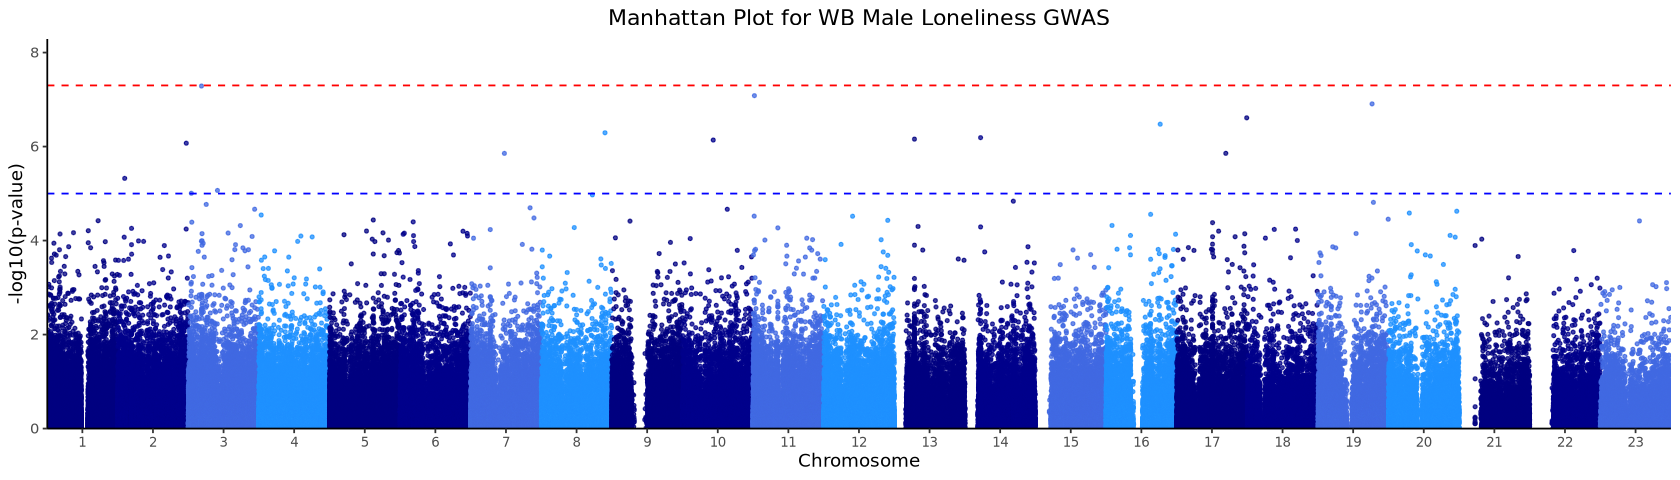

In [24]:
library(dplyr)
library(ggplot2)
library(scales)

plot_manhattan_equal_bins <- function(df,
                                      snp_col    = "SNP",
                                      chr_col    = "CHR",
                                      bp_col     = "BP",
                                      p_col      = "P",
                                      title      = "Manhattan Plot",
                                      suggestive = 1e-5,
                                      genomewide = 5e-8) {
  # 1) filter out NA or zero p’s
  df_clean <- df %>%
    filter(!is.na(.data[[p_col]]), .data[[p_col]] > 0)
  
  # 2) get the sorted list of chromosomes present
  chr_levels <- sort(unique(as.integer(df_clean[[chr_col]])))
  
  # 3) compute fraction along each chromosome, then equal‐bin x‐position
  df2 <- df_clean %>%
    transmute(
      SNP = .data[[snp_col]],
      CHR = as.integer(.data[[chr_col]]),
      BP  = as.integer(.data[[bp_col]]),
      P   = .data[[p_col]]
    ) %>%
    group_by(CHR) %>%
      mutate(
        max_bp = max(BP),
        frac   = BP / max_bp
      ) %>%
    ungroup() %>%
    mutate(
      chr_i       = match(CHR, chr_levels),      # 1,2,3...
      pos_eq      = (chr_i - 1) + frac,           # chr 1 → [0,1), chr 2 → [1,2), …
      neg_log10_p = -log10(P)
    )
  
  # 4) axis tick positions at the centre of each 1-unit bin
  axis_df <- data.frame(
    CHR    = chr_levels,
    center = seq_along(chr_levels) - 0.5
  )
  
  # 5) build the same navy/blue4/royalblue/dodgerblue cycle
  col_vec <- rep(c("navy", "blue4", "royalblue", "dodgerblue"),
                 length.out = length(chr_levels))
  names(col_vec) <- chr_levels
  
  # 6) finally, plot
  ggplot(df2, aes(x = pos_eq, y = neg_log10_p, color = factor(CHR))) +
    geom_point(alpha = 0.75, size = 0.8) +
    scale_color_manual(values = col_vec) +
    scale_x_continuous(
      breaks = axis_df$center,
      labels = axis_df$CHR,
      expand = c(0, 0)
    ) +
    scale_y_continuous(
      limits = c(0, max(df2$neg_log10_p) + 1),
      expand = c(0, 0)
    ) +
    geom_hline(yintercept = -log10(suggestive),
               linetype = "dashed", color = "blue") +
    geom_hline(yintercept = -log10(genomewide),
               linetype = "dashed", color = "red") +
    theme_classic() +
    theme(
      legend.position      = "none",
      panel.grid.major.x   = element_blank(),
      panel.grid.minor     = element_blank(),
      axis.text.x          = element_text(size = 8),
      axis.ticks.x         = element_line(),
      plot.title           = element_text(hjust = 0.5)
    ) +
    labs(
      title = title,
      x     = "Chromosome",
      y     = "-log10(p-value)"
    )
}

# Manhattan Plots

## Loneliness

### Males

In [25]:
male_unpruned <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/loneliness/WB_Male/Loneliness.glm.tsv.gz"
)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”


In [26]:
male_pruned <- male_unpruned %>% rename(P_male = P) %>% semi_join(prune_df, by = "SNP")

Warning message:
“Removed 238 rows containing missing values or values outside the scale range (`geom_point()`).”


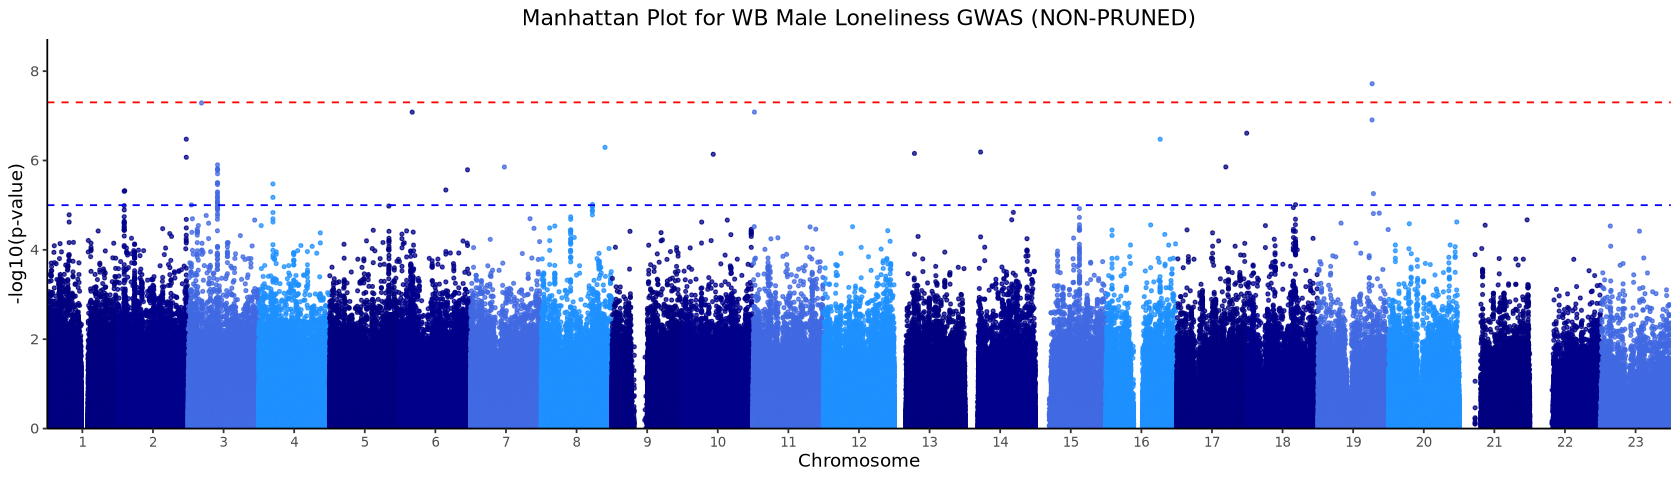

In [29]:
plot_manhattan_equal_bins(
  df     = male_unpruned,
  p_col  = "P",
  title  = "Manhattan Plot for WB Male Loneliness GWAS (NON-PRUNED)"
)

Warning message:
“Removed 100 rows containing missing values or values outside the scale range (`geom_point()`).”


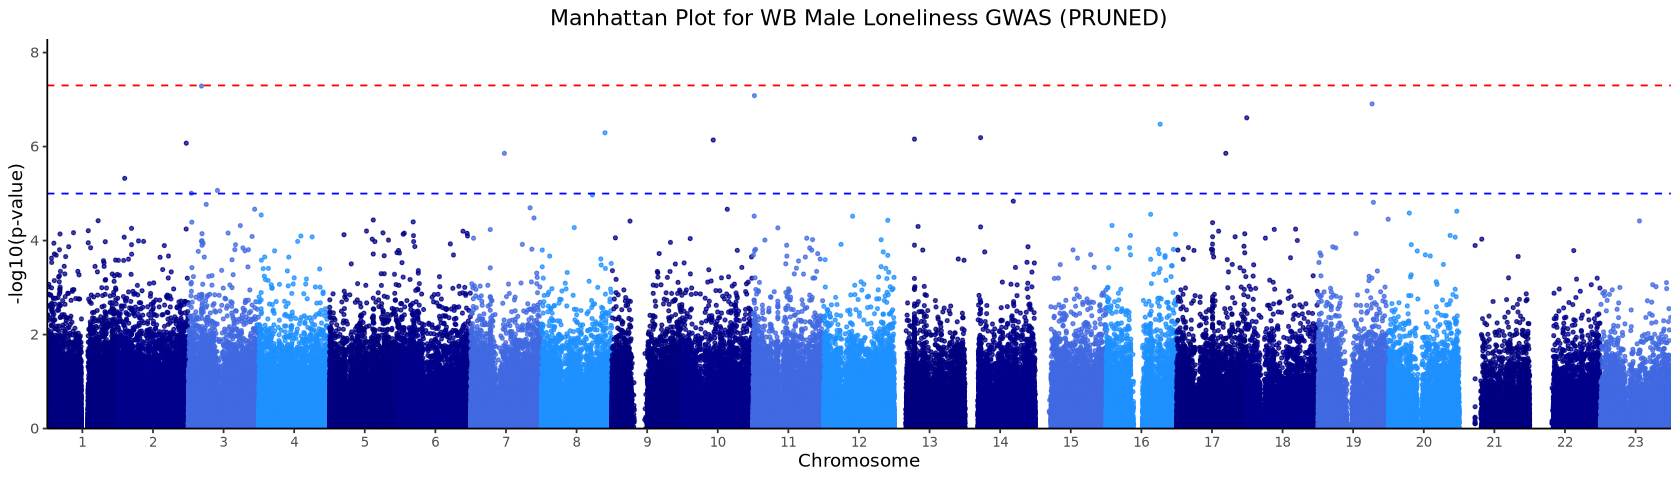

In [30]:
plot_manhattan_equal_bins(
  df     = male_pruned,
  p_col  = "P_male",
  title  = "Manhattan Plot for WB Male Loneliness GWAS (PRUNED)"
)

### Females

In [31]:
female_unpruned <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/loneliness/WB_Female/Loneliness.glm.tsv.gz"
)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”


In [35]:
female_pruned <- female_unpruned %>% rename(P_female = P) %>% semi_join(prune_df, by = "SNP")

Warning message:
“Removed 237 rows containing missing values or values outside the scale range (`geom_point()`).”


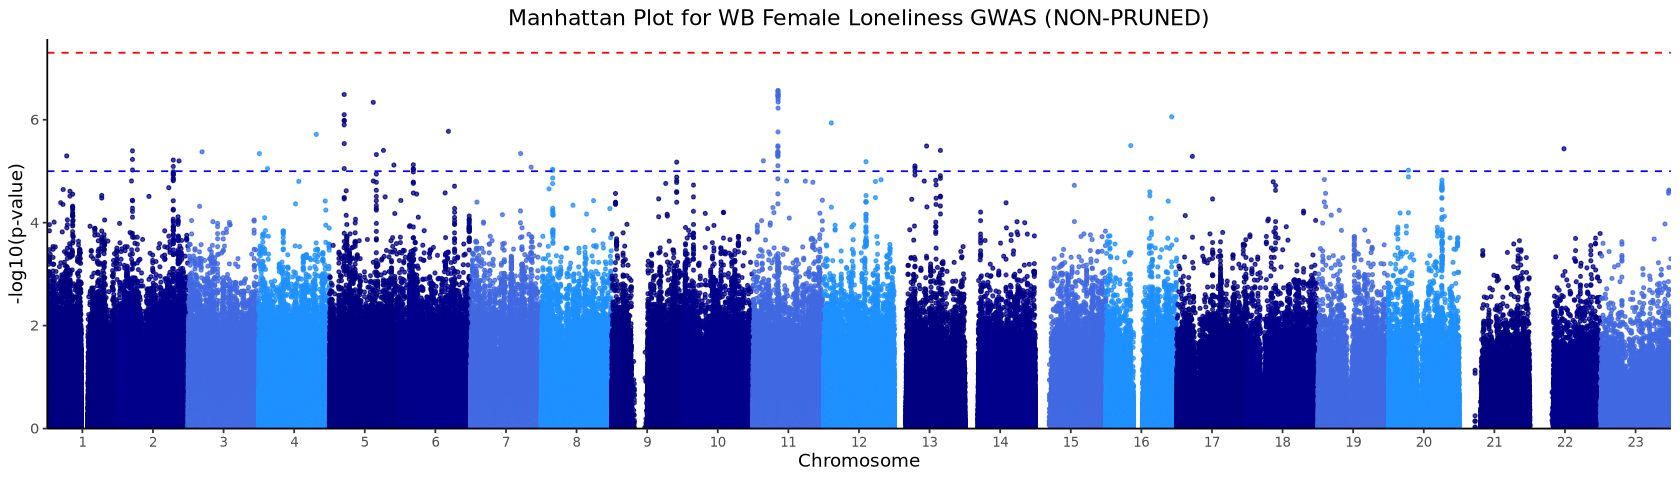

In [33]:
plot_manhattan_equal_bins(
  df     = female_unpruned,
  p_col  = "P",
  title  = "Manhattan Plot for WB Female Loneliness GWAS (NON-PRUNED)"
)

Warning message:
“Removed 99 rows containing missing values or values outside the scale range (`geom_point()`).”


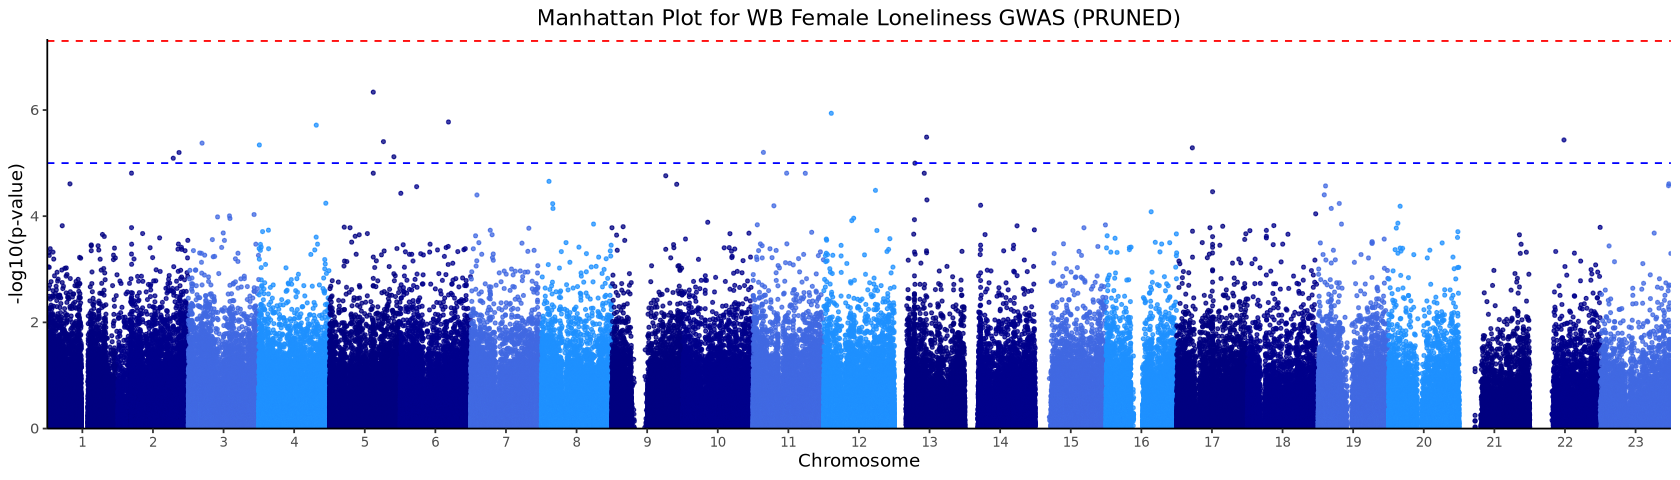

In [36]:
plot_manhattan_equal_bins(
  df     = female_pruned,
  p_col  = "P_female",
  title  = "Manhattan Plot for WB Female Loneliness GWAS (PRUNED)"
)

## Ability To Confide

### Male

In [37]:
male_unpruned <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/AbilityToConfide/WB_Male/AbilityToConfide.glm.tsv.gz"
)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”


In [38]:
male_pruned <- male_unpruned %>% rename(P_male = P) %>% semi_join(prune_df, by = "SNP")

Warning message:
“Removed 238 rows containing missing values or values outside the scale range (`geom_point()`).”


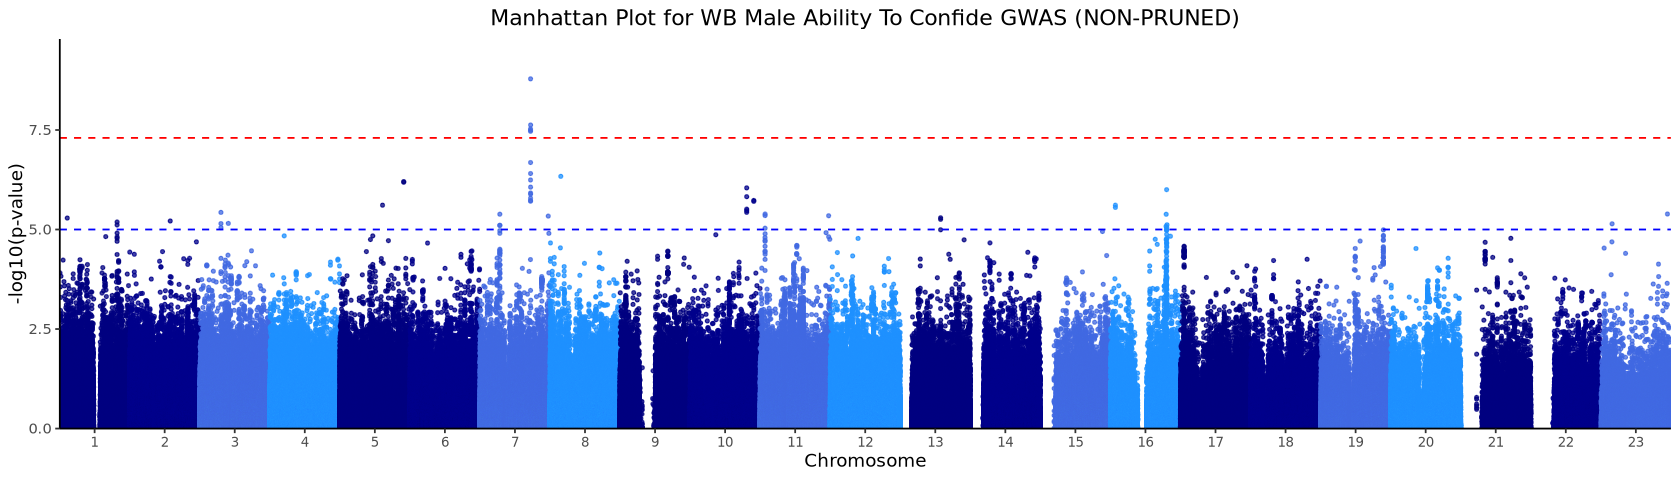

In [39]:
plot_manhattan_equal_bins(
  df     = male_unpruned,
  p_col  = "P",
  title  = "Manhattan Plot for WB Male Ability To Confide GWAS (NON-PRUNED)"
)

Warning message:
“Removed 100 rows containing missing values or values outside the scale range (`geom_point()`).”


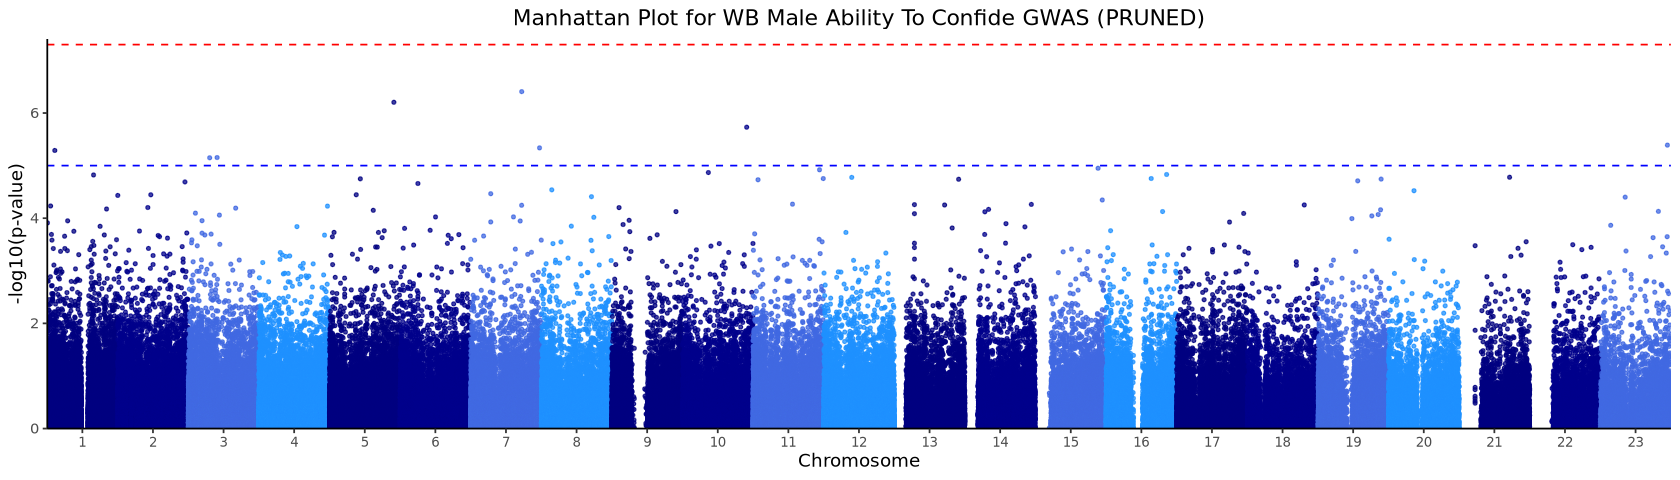

In [42]:
plot_manhattan_equal_bins(
  df     = male_pruned,
  p_col  = "P_male",
  title  = "Manhattan Plot for WB Male Ability To Confide GWAS (PRUNED)"
)

### Female

In [43]:
female_unpruned <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/AbilityToConfide/WB_Female/AbilityToConfide.glm.tsv.gz"
)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”


In [46]:
female_pruned <- female_unpruned %>% rename(P_female = P) %>% semi_join(prune_df, by = "SNP")

Warning message:
“Removed 237 rows containing missing values or values outside the scale range (`geom_point()`).”


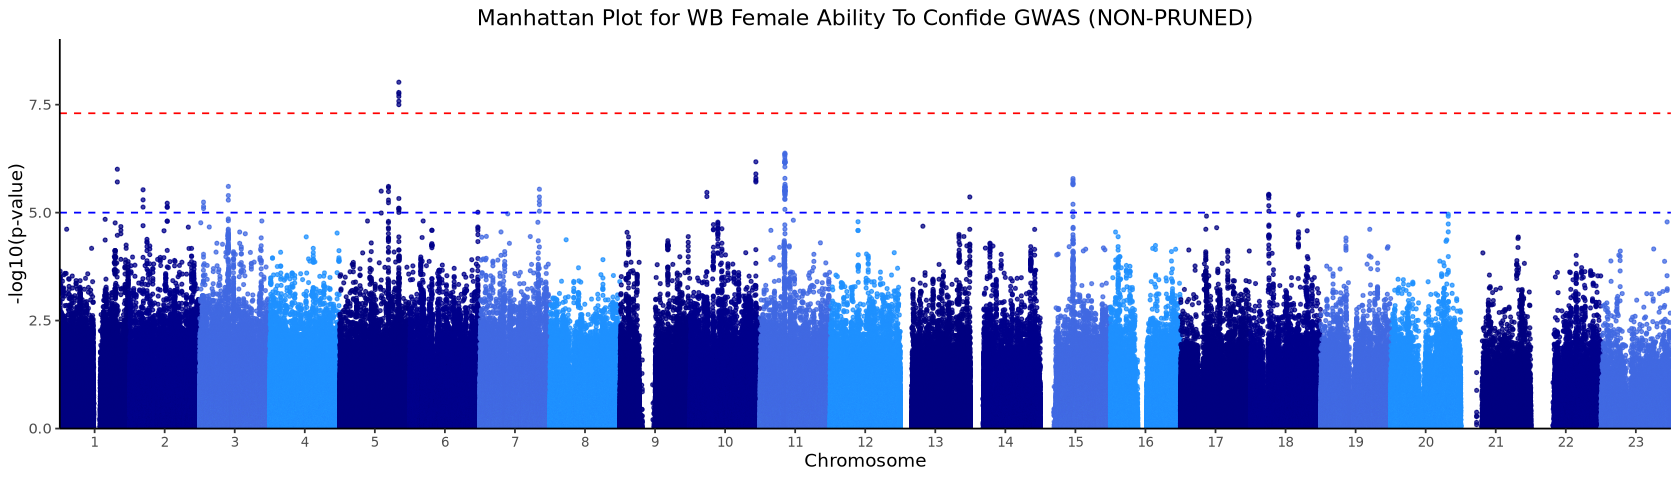

In [45]:
plot_manhattan_equal_bins(
  df     = female_unpruned,
  p_col  = "P",
  title  = "Manhattan Plot for WB Female Ability To Confide GWAS (NON-PRUNED)"
)

Warning message:
“Removed 99 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_hline()`).”


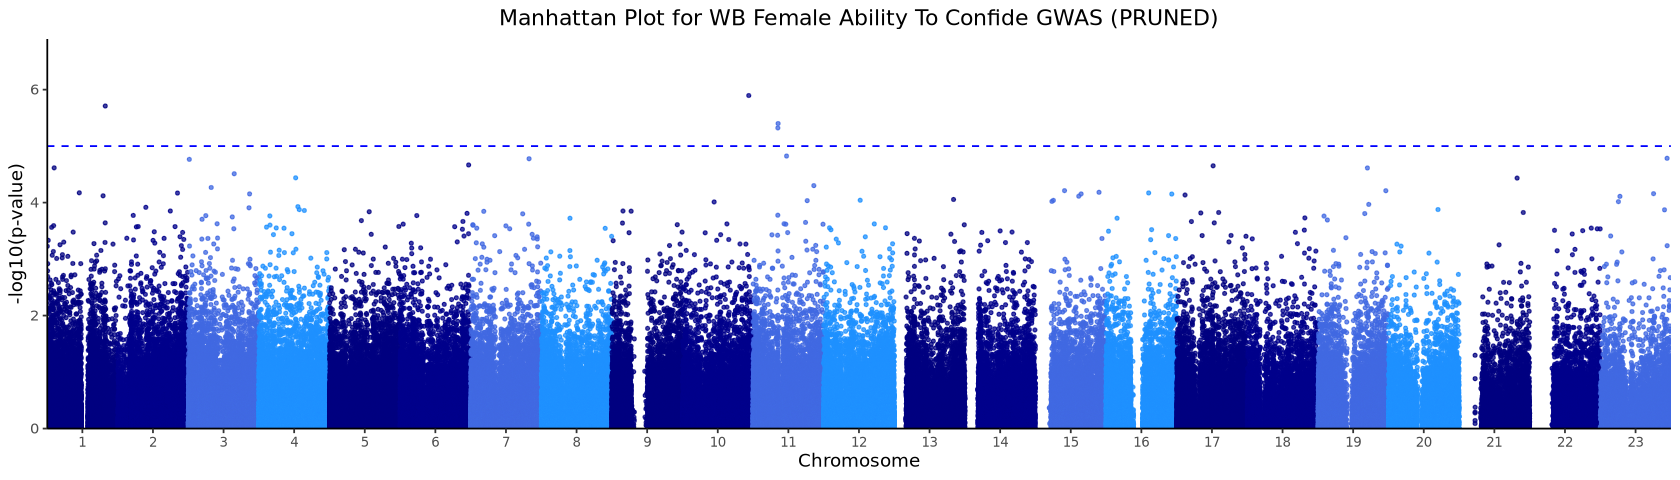

In [47]:
plot_manhattan_equal_bins(
  df     = female_pruned,
  p_col  = "P_female",
  title  = "Manhattan Plot for WB Female Ability To Confide GWAS (PRUNED)"
)

## Leisure And Social Activities

## Males

In [49]:
male_unpruned <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/LeisureSocialActivities/WB_Male/LeisureSocialActivities.glm.tsv.gz"
)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”


In [50]:
male_pruned <- male_unpruned %>% rename(P_male = P) %>% semi_join(prune_df, by = "SNP")

Warning message:
“Removed 238 rows containing missing values or values outside the scale range (`geom_point()`).”


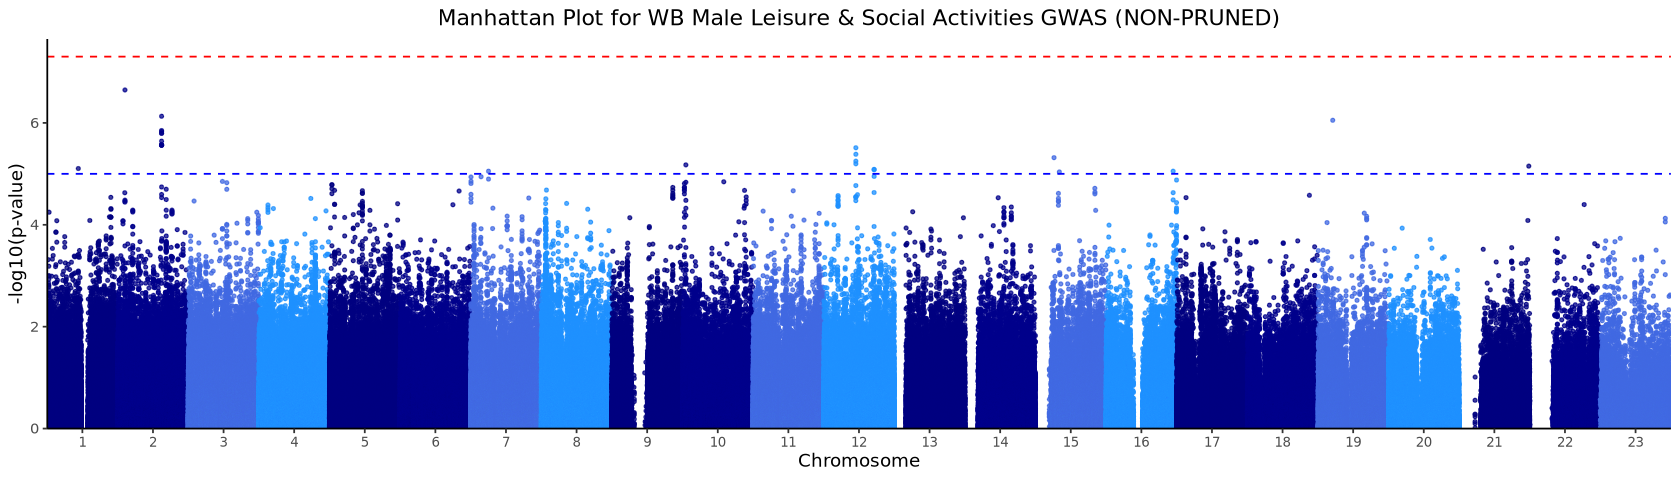

In [51]:
plot_manhattan_equal_bins(
  df     = male_unpruned,
  p_col  = "P",
  title  = "Manhattan Plot for WB Male Leisure & Social Activities GWAS (NON-PRUNED)"
)

Warning message:
“Removed 100 rows containing missing values or values outside the scale range (`geom_point()`).”


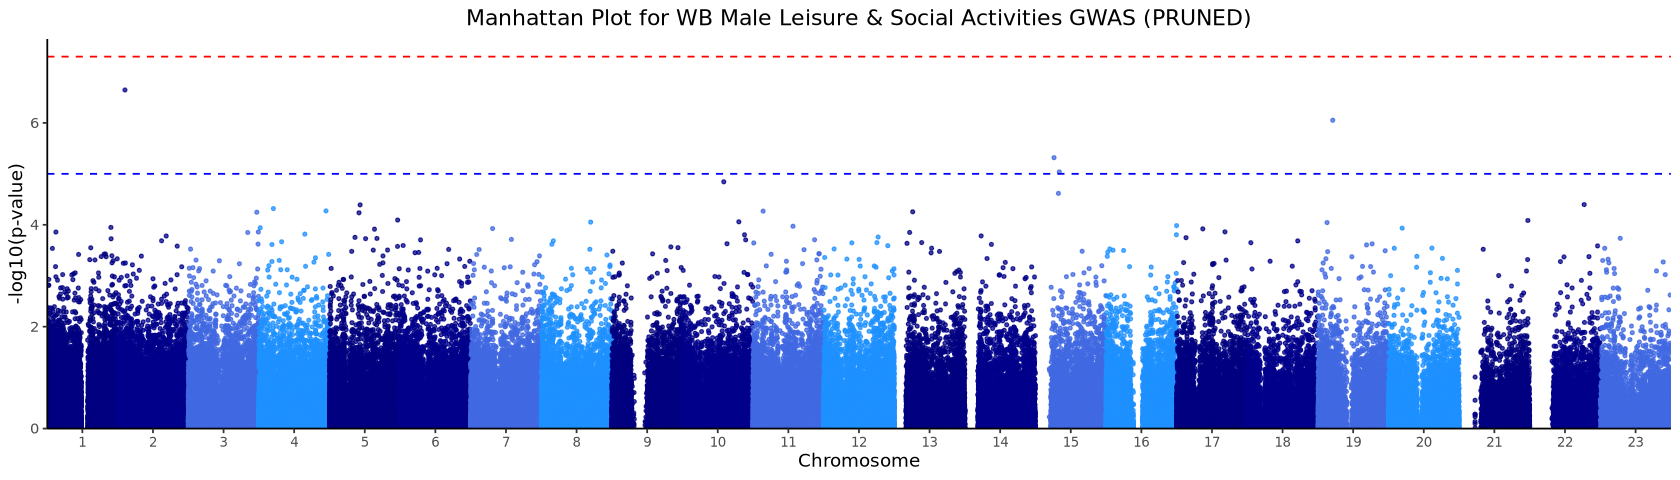

In [52]:
plot_manhattan_equal_bins(
  df     = male_pruned,
  p_col  = "P_male",
  title  = "Manhattan Plot for WB Male Leisure & Social Activities GWAS (PRUNED)"
)

### Females

In [53]:
female_unpruned <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/LeisureSocialActivities/WB_Female/LeisureSocialActivities.glm.tsv.gz"
)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”


In [54]:
female_pruned <- female_unpruned %>% rename(P_female = P) %>% semi_join(prune_df, by = "SNP")

Warning message:
“Removed 237 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_hline()`).”


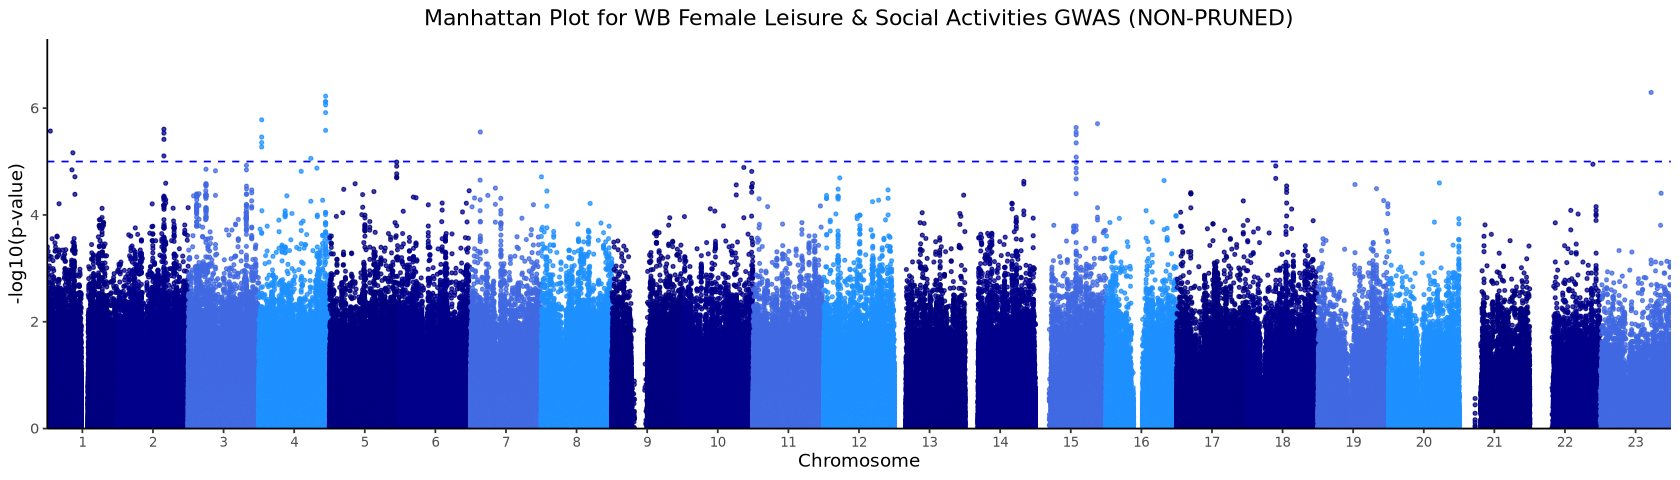

In [55]:
plot_manhattan_equal_bins(
  df     = female_unpruned,
  p_col  = "P",
  title  = "Manhattan Plot for WB Female Leisure & Social Activities GWAS (NON-PRUNED)"
)

Warning message:
“Removed 99 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_hline()`).”


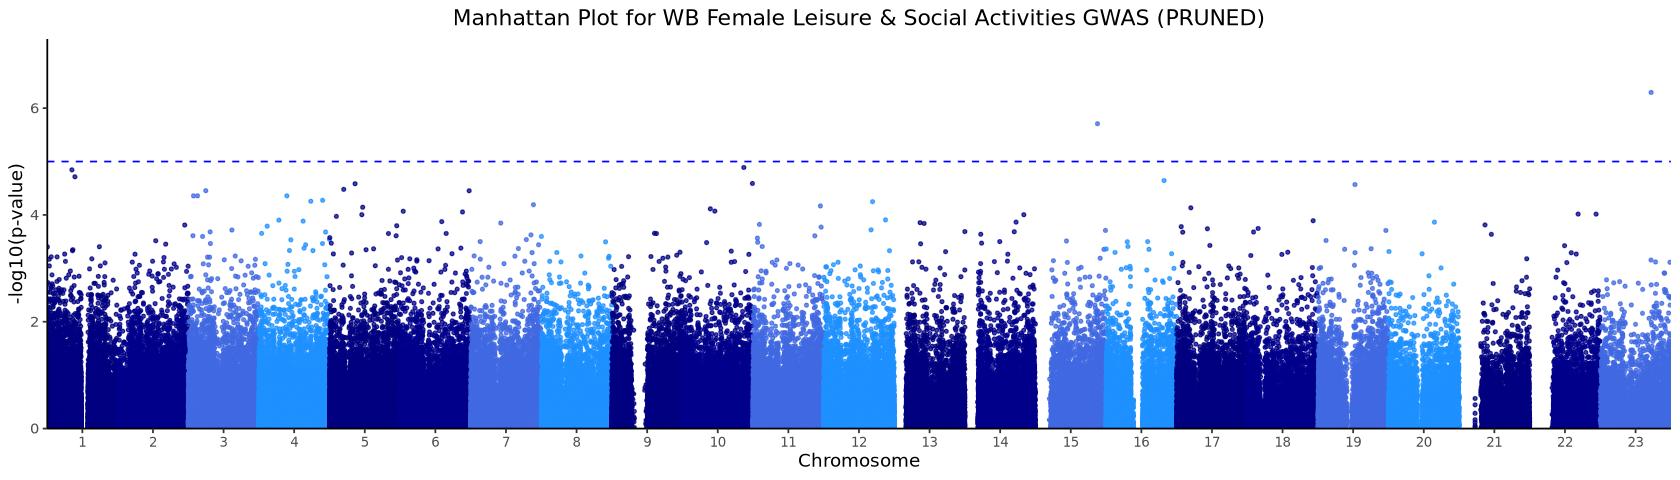

In [56]:
plot_manhattan_equal_bins(
  df     = female_pruned,
  p_col  = "P_female",
  title  = "Manhattan Plot for WB Female Leisure & Social Activities GWAS (PRUNED)"
)